# find the most different belief vs state trials

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# imports
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])

In [4]:
sys.path.append(os.path.abspath(workdir))
sys.path.append(os.path.abspath(workdir/'test'))
# os.chdir(workdir/'test/neural')
os.chdir(workdir)

In [5]:

from sklearn.model_selection import cross_val_predict, cross_val_score
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt
from firefly_utils.data_handler import data_handler
from firefly_utils.behav_class import *
from scipy.io import loadmat
import pickle
from InverseFuncs import *
from monkey_functions import *
from env_config import Config
from notification import notify
from pathlib import Path
from plot_ult import *
import scipy.interpolate as interpolate
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr

### Load neural data (.mat file) and behaviral data (from IRC)
the neural data file also has some behaivral data, such as current velocity.
we can use this as a sanity check to making sure things are right.

In [6]:
# load neural data

# this is a example session with good recording, more neurons
dat = loadmat(resdir/'neuraltest/m53s31.mat')
# dat = loadmat(resdir/'neural/m53s36.mat') # this is a pert example


behav_stat_key = 'behv_stats'
spike_key = 'units'
behav_dat_key = 'trials_behv'
lfp_key = 'lfps'

pre_trial_dur = 0.5
post_trial_dur = 0.5
exp_data = data_handler(dat, behav_dat_key, spike_key, lfp_key,
                        behav_stat_key, pre_trial_dur=pre_trial_dur,             extract_fly_and_monkey_xy=True,
                        post_trial_dur=post_trial_dur, extract_cartesian_eye_and_firefly=True,
                        lfp_beta=None, lfp_alpha=None, extract_lfp_phase=True)

# list(exp_data.behav.continuous.__dict__.keys())
exp_data.set_filters('all', True)
ts = exp_data.rebin_time_stamps(0.1)
t_targ = dict_to_vec(exp_data.behav.events.t_targ)
t_start = t_targ
t_stop = dict_to_vec(exp_data.behav.events.t_stop)
var_names = 'rad_vel', 'ang_vel', 'x_monk', 'y_monk', 'eye_hori', 'eye_vert', 'x_fly_screen', 'z_fly_screen', 'x_eye_screen', 'z_eye_screen', "x_fly_rel", "y_fly_rel", "ang_vel"
y, X, trial_idx = exp_data.concatenate_inputs(
    *var_names, t_start=t_start, t_stop=t_stop, time_stamps=ts)

trials = np.unique(trial_idx)
yes = 0
total = 0
for itrial in range(len(trials)):
    if len(X['x_fly_rel'][trial_idx == trials[itrial]]) < 1:
        continue
    d = (X['x_fly_rel'][trial_idx == trials[itrial]][-1]**2 +
         X['y_fly_rel'][trial_idx == trials[itrial]][-1]**2)**0.5
    if d < 65:
        yes += 1
    total += 1
print(f'number of trial: {len(trials)}, \nsession success rate is ', yes/total)


brainarea = dat['units']['brain_area']

unable to extract pairs, different blocks number
no eyetracking...
no normalized t_ptb (t_ptbn)
['all', 'reward', 'density', 'ptb', 'microstim', 'landmark', 'replay', 'controlgain', 'firefly_fullON']
Succesfully set filter
number of trial: 700, 
session success rate is  0.5642857142857143


In [7]:
# load behavioral data

with open(resdir/'neuraltest/res/m53s31_0928newformatbelief', 'rb') as f:
    res = pickle.load(f)

y_ = res['y']
X_mat = X
X = {k: res[k] for k in ['rad_vel', 'ang_vel', 'x_monk', 'y_monk']}
trial_idx = res['trial_idx']
beliefs = res['belief']
covs = res['covs']
mask = res['mask']
s = np.vstack([v for v in X.values()])
s = s.T

In [8]:
# use b-spline to process neural data

kernel_len = 7  # should be about +- 325ms
knots = np.hstack(([-1.001]*3, np.linspace(-1.001, 1.001, 5), [1.001]*3))
tp = np.linspace(-1., 1., kernel_len)
bX = splineDesign(knots, tp, ord=4, der=0, outer_ok=False)

# with initiate_plot(3, 2, 200) as f:
#     ax = f.add_subplot(111)
#     plt.plot(bX)
#     plt.title('B-spline kernel')
#     quickspine(ax)
#     plt.xticks([0, kernel_len-1])
#     ax.set_xticklabels([-kernel_len*50, kernel_len*50])
#     plt.xlabel('time, ms')
#     plt.ylabel('coef')


with suppress():
    modelX = convolve_loop(y_.T, trial_idx, bX)  # ts, neurons
pos_xy = np.hstack((X['x_monk'].reshape(-1, 1),
                   X['y_monk'].reshape(-1, 1)))  # ts, xy
# remove bad data
non_nan = ~np.isnan(pos_xy.sum(axis=1))
modelX = modelX[non_nan]
pos_xy = pos_xy[non_nan]
belief_xy = beliefs[:, [0, 1]][non_nan]

In [9]:
# calculate relative beliefs and states

states_rel, belief_rel = [], []
for itrial in range(len(trials)):
    xr, yr = world2mk(X['x_monk'][trial_idx == trials[itrial]], X['y_monk'][trial_idx == trials[itrial]], X['ang_vel'][trial_idx ==
                      trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    states_rel.append(np.vstack([xr, yr]))

    xr, yr = world2mk(beliefs[trial_idx == trials[itrial]][:, 0], beliefs[trial_idx == trials[itrial]][:, 1], X['ang_vel']
                      [trial_idx == trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    belief_rel.append(np.vstack([xr, yr]))

states_rel = np.hstack(states_rel).T
belief_rel = np.hstack(belief_rel).T

In [10]:
# calculate the relative cov (rotate ccw 180+heading from mid degree)

belief_heading = beliefs[:, 2][non_nan]
rotdegree = belief_heading+180
relativeposcov = []
for degree, thiscov in zip(rotdegree, covs):
    R = np.array([[np.cos(-degree/180*pi), -np.sin(-degree/180*pi)],
                 [np.sin(-degree/180*pi), np.cos(-degree/180*pi)]])
    relativeposcov.append(R.T@thiscov[:2, :2]@R)
relativeposcov = np.stack(relativeposcov)
relativeposcov.shape

(11331, 2, 2)

In [11]:
# uncertainty var and std from cov.

uncertainty_var = [c[:2, :2].flatten()[[0, 3]] for c in relativeposcov]
uncertainty_var = np.array(uncertainty_var)
uncertainty_std = np.power(uncertainty_var, 0.5)[:,]

In [12]:
# time

trialtime = []
fulltime = np.arange(0, 7, 0.1)
for itrial in range(len(trials)):
    thistime = len(X['x_monk'][trial_idx == trials[itrial]])
    trialtime.append(fulltime[:thistime])
trialtime = np.hstack(trialtime).T

trialtime = trialtime.reshape(-1, 1)

In [13]:
# cumulative distance traveled and angle turned

pathtraveled = []
for itrial in range(len(trials)):
    thisv = np.cumsum(X['rad_vel'][trial_idx == trials[itrial]])
    thisw = np.cumsum(X['ang_vel'][trial_idx == trials[itrial]])
    pathtraveled.append(np.stack([thisv, thisw]))
pathtraveled = np.hstack(pathtraveled).T

In [14]:
# eye

eyeh = X_mat['eye_hori'][mask[0]][mask[1]]
eyev = X_mat['eye_vert'][mask[0]][mask[1]]

# belief vs state

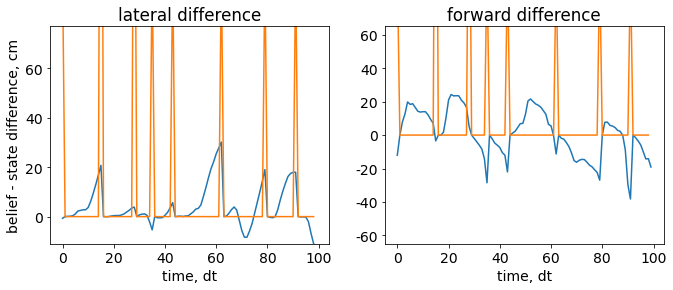

In [51]:
s=8000
e=s+100

fig, axs=plt.subplots(1,2, figsize=(11,4))
ax=axs[0]
ax.plot(belief_rel[s:e,0]-states_rel[s:e,0])
ax.plot(np.diff(trial_idx[s:e])*100)
ax.set_ylim(-11,77)
ax.set_xlabel('time, dt')
ax.set_ylabel('belief - state difference, cm')
ax.set_title('lateral difference')

ax=axs[1]
plt.plot(belief_rel[s:e,1]-states_rel[s:e,1])
plt.plot(np.diff(trial_idx[s:e])*100)
plt.xlabel('time, dt')
# plt.ylabel('belief - state difference, forward, cm')
plt.ylim(-65,65)
ax.set_title('forward difference')

plt.show()

### comments
there are some difference.